In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import scipy as sp
import sys,os
sys.path.append('../../')
from gammaPAC.gammaPAC import *
from gammaPAC.generalPAC import *
from gammaPAC.utils.synthetic_data import *
fig_dir = ... # path to save figures

from joblib import Parallel, delayed
from multiprocessing import cpu_count
import time

In [15]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.figsize'] = (8,6)

## Simulated Data

The mutual information between the low frequency phase and high frequency amplitude is: 0.0888


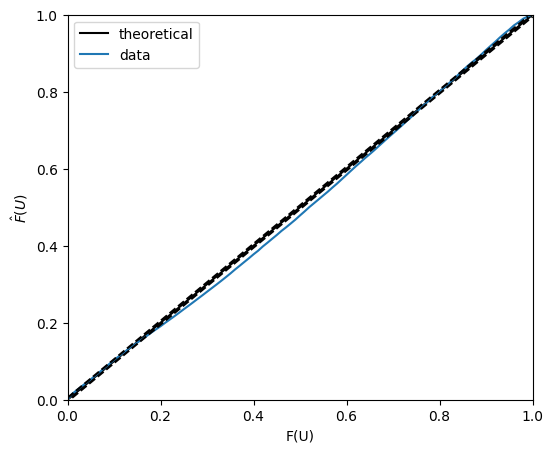

In [60]:
#set random seed for reproducibility
np.random.seed(12345)

#generate synthetic data
fs = 250 #Hz - sampling rate
t = np.arange(0,300,1/fs) #time vector
flow = 2 #Hz - low frequency
fhigh= 10 #Hz - high frequency
coupling = 0.2 #coupling strength
noise_var = .5 #noise variance

signal = generate_coupled_EEG_sig(t,flow,fhigh,coupling,noise_var) #generate coupled signal
pac = GammaPAC(signal,signal,fs) #initialize GammaPAC object
pac.fit(1,[1,3],[7,13]) #fit PAC model
print(f'The mutual information between the low frequency phase and high frequency amplitude is: {pac.PAC:.4f}')
pac.plotGOF(); #plot goodness of fit


## Simulated time varying data

Text(0.5, 0, 'Time (s)')

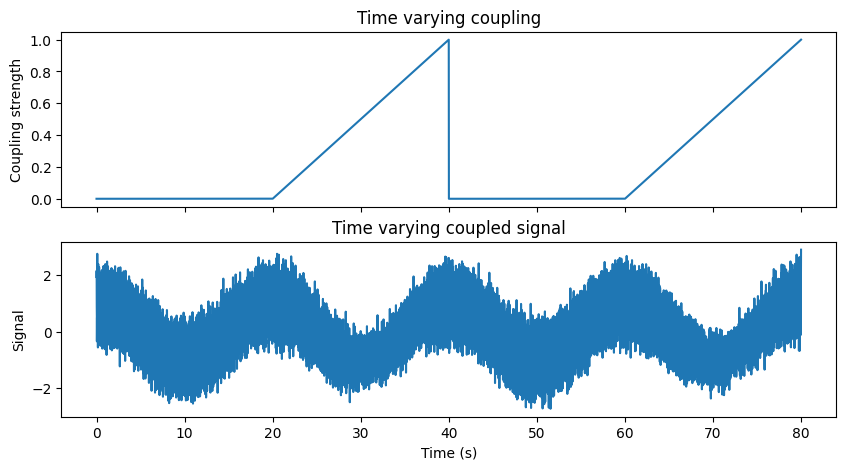

In [61]:
np.random.seed(12345) #set random seed for reproducibility
fs = 250 #Hz
flow = .05 #Hz - low frequency
fhigh = 10 #Hz - high frequency
time = np.arange(0,80,1/fs)#linspace(0,5,501)

# cc_time_series = 0.7*(sp.signal.square(time*np.pi/20,0.5)+1)/2 #generate time varying coupling using square wave
cc_time_series = generate_ramp(time,20)[np.where(time <=time[-1])] #generate time varying coupling using ramp function

tvc_signal = generate_time_varying_coupled_sig(time, flow=flow ,fhigh=fhigh,cc_time_series =  cc_time_series ,noise_var = 0.1) #generate time varying coupled signal

#plot time varying coupling and time varying coupled signal
fig,ax = plt.subplots(2,1,figsize=(10,5),sharex=True)
ax[0].plot(time,cc_time_series)
ax[0].set_title('Time varying coupling')
ax[0].set_ylabel('Coupling strength')

ax[1].plot(time, tvc_signal)
ax[1].set_title('Time varying coupled signal')
ax[1].set_ylabel('Signal')
ax[1].set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

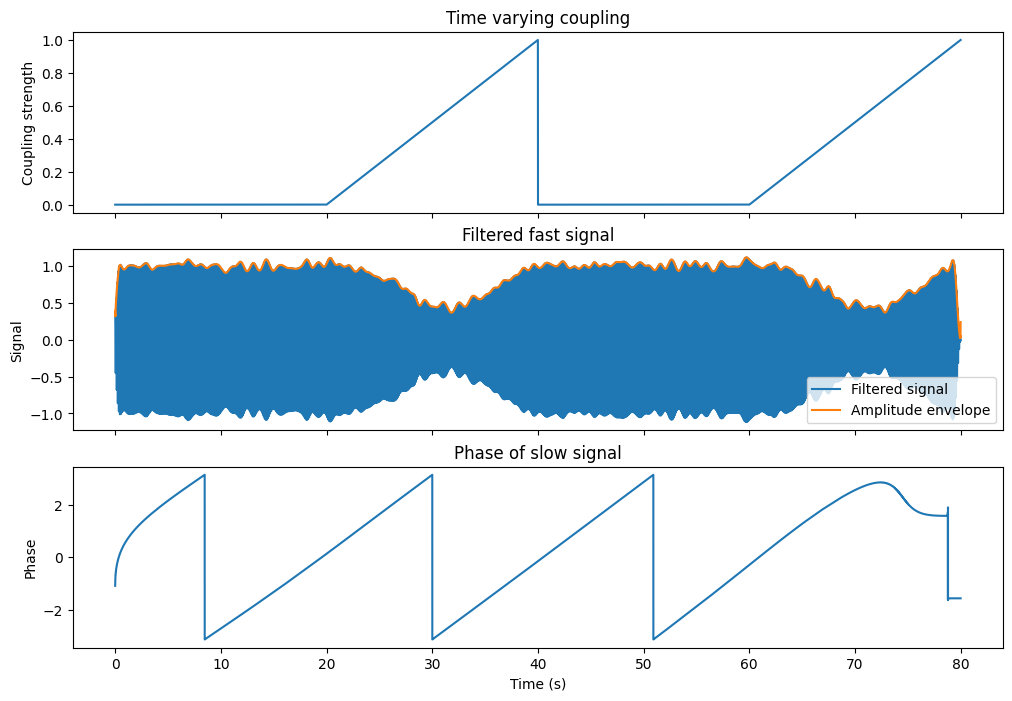

In [62]:
#filter the time varying coupled signal to extract the fast signal and slow signal
sos = sp.signal.butter(4,[fhigh-flow-1,fhigh+flow+1],'bandpass',output = "sos",fs = fs)
fsig = sp.signal.sosfiltfilt(sos,tvc_signal)
famp = np.abs(sp.signal.hilbert(fsig))
try:
  sos = sp.signal.butter(4,[flow-1,flow+1],'bandpass',output = "sos",fs = fs)
except:
  sos = sp.signal.butter(4,[flow-.02,flow+.02],'bandpass',output = "sos",fs = fs)
ssig = sp.signal.sosfiltfilt(sos,tvc_signal)
sphase = np.angle(sp.signal.hilbert(ssig))

fig,ax = plt.subplots(3,1,figsize=(12,8),sharex=True)
ax[0].plot(time,cc_time_series)
ax[0].set_title('Time varying coupling')
ax[0].set_ylabel('Coupling strength')

ax[1].plot(time,fsig)
ax[1].plot(time,famp)
ax[1].set_title('Filtered fast signal')
ax[1].set_ylabel('Signal')
ax[1].legend(['Filtered signal','Amplitude envelope'])

ax[2].plot(time,sphase)
ax[2].set_title('Phase of slow signal')
ax[2].set_ylabel('Phase')
ax[2].set_xlabel('Time (s)')



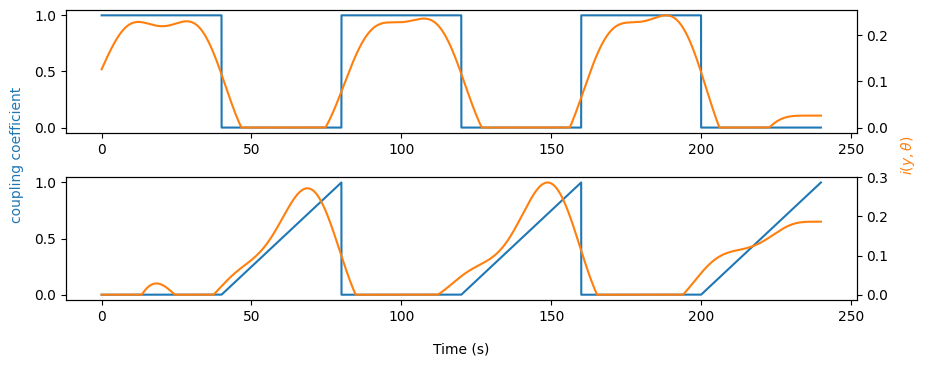

In [13]:
np.random.seed(12345)
fs = 250 #Hz
flow = .05
fhigh = 10
time = np.arange(0,240,1/fs)#linspace(0,5,501)

period = 40
cc_list = []
tvc_list = []
cc_list.append((sp.signal.square(time*np.pi/period,0.5)+1)/2)
cc_list.append(generate_ramp(time,period)[np.where(time <=time[-1])])

for i in range(len(cc_list)):
  tvc_signal = generate_time_varying_coupled_sig(time, flow=flow ,fhigh=fhigh,cc_time_series =  cc_list[i] ,noise_var = 0.1)
  tvc_list.append(tvc_signal)
n_timeseries = len(cc_list)

fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot()
ax.set_xlabel('Time (s)', labelpad=30)
ax.set_ylabel('coupling coefficient', c = "tab:blue",labelpad=30)
ax.set_xticks([])
ax.set_yticks([])
[ax.spines[side].set_visible(False) for side in ('left', 'top', 'right', 'bottom')]
ax.patch.set_visible(False)

ax = fig.add_subplot()
ax.yaxis.set_label_position('right')
ax.set_ylabel(r'$i(y,\theta)$', c = "tab:orange", labelpad=30)
ax.set_xticks([])
ax.set_yticks([])
[ax.spines[side].set_visible(False) for side in ('left', 'top', 'right', 'bottom')]
ax.patch.set_visible(False)

for i in range(n_timeseries):

  p2 = GammaPAC(tvc_list[i],tvc_list[i],fs)
  try:
    p2.fit(1,[flow-1,flow+1],[fhigh-flow-1,fhigh+flow+1])
  except:
    p2.fit(1,[flow-.02,flow+.02],[fhigh-flow-1,fhigh+flow+1])
  idpac = p2.idPAC(filtOutput=True)

  ax = fig.add_subplot(n_timeseries, 1, i + 1)


  ax.plot(time,cc_list[i],label = 'coupling coefficient')
  ax2 = ax.twinx()

  ax2.plot(time,idpac,c = "tab:orange",label = "idPAC")
  fig.tight_layout()

#plt.savefig(fig_dir+f'infodensity_gutalph_p{period}.png',dpi = 400)

## ERPAC Simulation

In [66]:
np.random.seed(12345)
fs = 50 #Hz
flow = .05
fhigh = 10
time = np.arange(0,120,1/fs)#linspace(0,5,501)
period = 40

dataERPAC = simulateERPACdata(time,flow,fhigh,period = period)

In [16]:
sosp = sp.signal.butter(6,[flow-.02,flow+.02],'bandpass',output = "sos",fs = fs)
sosa = sp.signal.butter(6,[fhigh-flow-1,fhigh+flow+1],'bandpass',output = "sos",fs=fs)

#filter the data to extract the slow and fast signals
slowERPAC = sp.signal.sosfiltfilt(sosp,dataERPAC,axis = -1)
fastERPAC = sp.signal.sosfiltfilt(sosa,dataERPAC,axis = -1)
phaseERPAC = np.angle(sp.signal.hilbert(slowERPAC,axis = 0))
ampERPAC = np.abs(sp.signal.hilbert(fastERPAC,axis = 0))

#extend the ERPAC data for by mirroring the data for half a slow cycle on both ends
pflip = np.fliplr(phaseERPAC)
phaseERPACstack = np.hstack((pflip[:,-fs*10:],phaseERPAC,pflip[:,:fs*10]))

aflip = np.fliplr(ampERPAC)
ampERPACstack = np.hstack((aflip[:,-fs*10:],ampERPAC,aflip[:,:fs*10]))


In [19]:
def idPAC_tmp(phase,amp,coeffs,K,alpha,lp = 1,fs = 1,filtOutput = True):
    marginalY = calc_fY(coeffs, amp,K ,alpha)
    idPAC = np.zeros_like(phase)
    for tt in range(phase.size):
        likelihood = fYgivenTheta(amp[tt],phase[tt],coeffs=coeffs,K= K,alpha= alpha)
        infoDensity = np.log(likelihood/marginalY[tt])
        idPAC[tt] = infoDensity
    if filtOutput:
        sos = sp.signal.butter(4,lp,'low',output  = 'sos',fs = fs)
        idPAC = sp.signal.sosfiltfilt(sos,idPAC)
        idPAC[np.where(idPAC < 0)] = 0
    return idPAC

def calcERPACt(phase,amp):
    T = phase.shape[1]
    pac,coeffs,alpha,K = calc_gammaPAC(phase.flatten(),amp.flatten(),K=1,modelSelection = False,sMethod = "MDL",penalty=0)
    erPAC = pac
    erID = idPAC_tmp(phase[:,T//2],amp[:,T//2],coeffs,K,alpha,lp = 1,fs = fs,filtOutput = False)
    return erPAC, erID

In [72]:
erPAC = np.zeros((dataERPAC.shape[1]))
erID = np.zeros_like(dataERPAC)

output = Parallel(n_jobs=cpu_count())(delayed(calcERPACt)(phaseERPACstack[:,i:i+fs*20],ampERPACstack[:,i:i+fs*20]) for i in range(dataERPAC.shape[1]))
erPAC = np.array([output[i][0] for i in range(len(output))])
erID = np.array([output[i][1] for i in range(len(output))]).T

### Plot ERPAC estimate against the coupling
- also plot unfiltered idPAC for each trial as a heatmap

Text(0.5, 1.0, 'Event Related Phase Amplitude Coupling (ERPAC)')

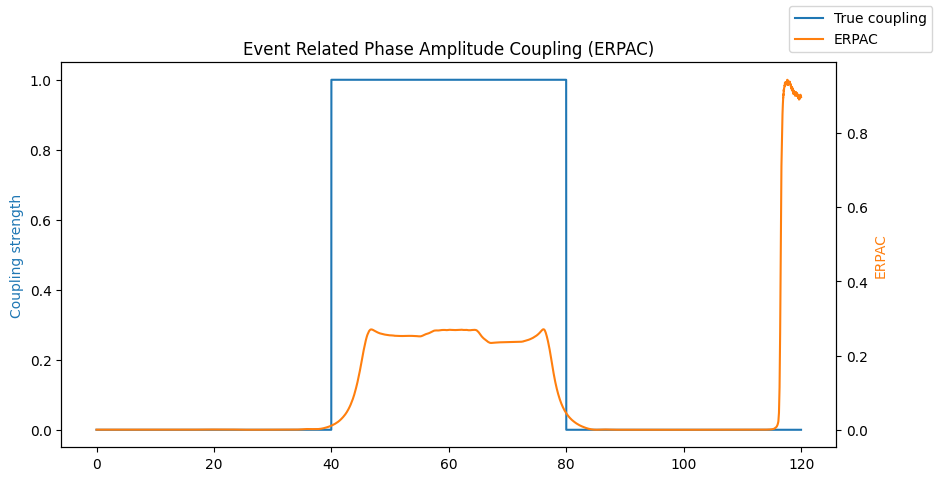

In [80]:
time = np.arange(0,120,1/fs)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(time,1-(sp.signal.square(time*np.pi/period,0.5)+1)/2,label = 'True coupling')
ax2 = ax.twinx()
ax2.plot(time,erPAC,label = 'ERPAC',c = "tab:orange")
fig.legend()
plt.xlabel('Time (s)')
ax.set_ylabel('Coupling strength',c = "tab:blue")
ax2.set_ylabel('ERPAC',c = "tab:orange")
ax.set_title('Event Related Phase Amplitude Coupling (ERPAC)')

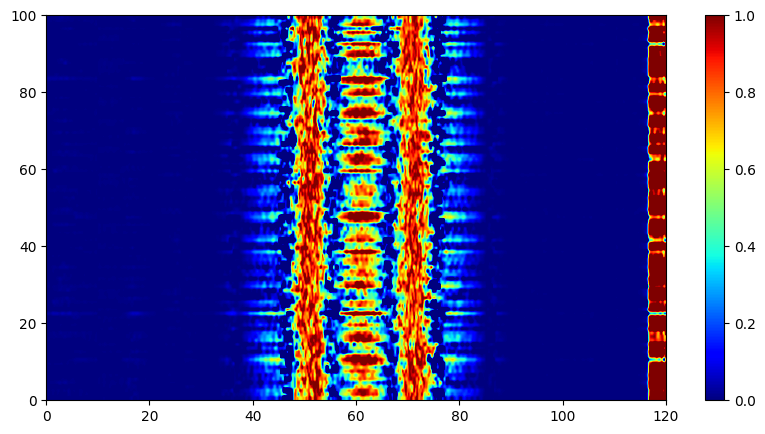

In [78]:
plt.figure(figsize=(10,5))
plt.imshow(erID,origin = 'lower',cmap = "jet",aspect='auto',extent = [0,120,0,erID.shape[0]])
plt.colorbar()
plt.clim(0,1)

### Plot filtered idPAC in a heatmap for each trial and its average across trials

- use as a comparison to the actual ERPAC paradigm

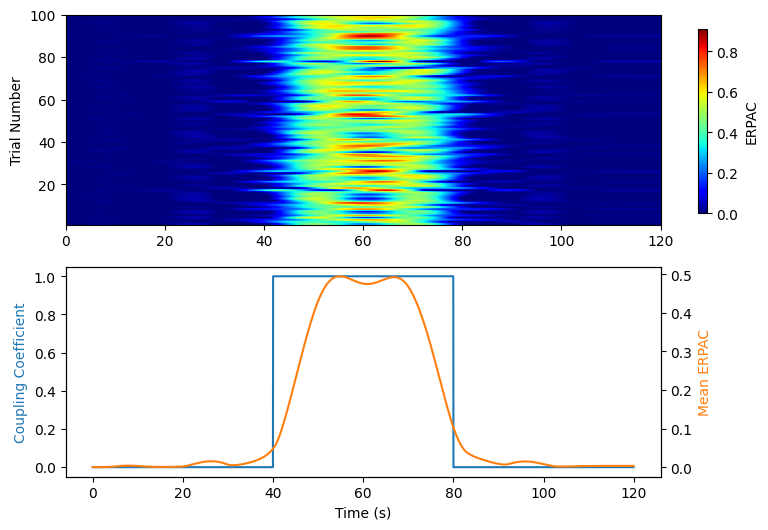

In [30]:
sim_tmp = erID#np.copy(idpac_sim)
fs = 50
sos_er = sp.signal.butter(6,.05,output="sos",fs = fs)
sim_tmp = sp.signal.sosfiltfilt(sos_er,sim_tmp,axis=-1)

sim_tmp[np.where(sim_tmp< 0)] = 0


fig,ax = plt.subplots(2,1,figsize = (10,6))
im =ax[0].imshow(sim_tmp,cmap = 'jet',aspect='auto',extent = [0,120,1,100])
fig.colorbar(im,ax = ax,shrink = .4,anchor = (-.25,.95),label = 'ERPAC')



#ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Trial Number')

time = np.arange(0,120,1/fs)#linspace(0,5,501)


#fig,ax = plt.subplots()
ax[1].plot(time,1-(sp.signal.square(time*np.pi/period,0.5)+1)/2)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Coupling Coefficient',c = "tab:blue")
ax2 = ax[1].twinx()
ax2.plot(time,np.mean(sim_tmp,axis = 0),c="tab:orange")
ax2.set_ylabel('Mean ERPAC',c = 'tab:orange')
plt.subplots_adjust(right=0.72,hspace=.2)
#plt.savefig(fig_dir+'ERPAC_plots.jpeg',dpi = 400,bbox_inches = 'tight')
